# Домашнее задание. Нейросетевая классификация текстов

В этом домашнем задании вам предстоит самостоятельно решить задачу классификации текстов на основе семинарского кода. Мы будем использовать датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

Установим модуль datasets, чтобы нам проще было работать с данными.

Импорт необходимых библиотек

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set(palette='summer')
default_model_path = 'models'

import os

# Создаем папку, если её нет
os.makedirs(default_model_path, exist_ok=True)

In [2]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jupyter/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Ваша задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

In [4]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

Как и в семинаре, выполним следующие шаги:
* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.

In [5]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

100%|██████████| 120000/120000 [00:30<00:00, 3949.56it/s]

Размер словаря: 11842


In [6]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ]
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])

    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [7]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [8]:
test_dataset = WordDataset(dataset['test'])

test_dataloader = DataLoader(
    test_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

## Ход работы
Оценка за домашнее задание складывается из четырех частей:
### Запуск базовой модели с семинара на новом датасете (1 балл)
На семинаре мы создали модель, которая дает на нашей задаче довольно высокое качество. Ваша цель --- обучить ее и вычислить `score`, который затем можно будет использовать в качестве бейзлайна.

В модели появится одно важное изменение: количество классов теперь равно не 2, а 4. Обратите на это внимание и найдите, что в коде создания модели нужно модифицировать, чтобы учесть это различие.

### Проведение экспериментов по улучшению модели (2 балла за каждый эксперимент)
Чтобы улучшить качество базовой модели, можно попробовать различные идеи экспериментов. Каждый выполненный эксперимент будет оцениваться в 2 балла. Для получения полного балла за этот пункт вам необходимо выполнить по крайней мере 2 эксперимента. Не расстраивайтесь, если какой-то эксперимент не дал вам прироста к качеству: он все равно зачтется, если выполнен корректно.

Вот несколько идей экспериментов:
* **Модель RNN**. Попробуйте другие нейросетевые модели --- LSTM и GRU. Мы советуем обратить внимание на [GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html), так как интерфейс этого класса ничем не отличается от обычной Vanilla RNN, которую мы использовали на семинаре.
* **Увеличение количества рекуррентных слоев модели**. Это можно сделать с помощью параметра `num_layers` в классе `nn.RNN`. В такой модели выходы первой RNN передаются в качестве входов второй RNN и так далее.
* **Изменение архитектуры после применения RNN**. В базовой модели используется агрегация со всех эмбеддингов. Возможно, вы захотите конкатенировать результат агрегации и эмбеддинг с последнего токена.
* **Подбор гиперпараметров и обучение до сходимости**. Возможно, для получения более высокого качества просто необходимо увеличить количество эпох обучения нейросети, а также попробовать различные гиперпараметры: размер словаря, `dropout_rate`, `hidden_dim`.

Обратите внимание, что главное правило проведения экспериментов --- необходимо совершать одно архитектурное изменение в одном эксперименте. Если вы совершите несколько изменений, то будет неясно, какое именно из изменений дало прирост к качеству.

### Получение высокого качества (3 балла)
В конце вашей работы вы должны указать, какая из моделей дала лучший результат, и вывести качество, которое дает лучшая модель, с помощью функции `evaluate`. Ваша модель будет оцениваться по метрике `accuracy` следующим образом:
* $accuracy < 0.9$ --- 0 баллов;
* $0.9 \leqslant accuracy < 0.91$ --- 1 балл;
* $0.91 \leqslant accuracy < 0.915$ --- 2 балла;
* $0.915 \leqslant accuracy$ --- 3 балла.

### Оформление отчета (2 балла)
В конце работы подробно опишите все проведенные эксперименты.
* Укажите, какие из экспериментов принесли улучшение, а какие --- нет.
* Проанализируйте графики сходимости моделей в проведенных экспериментах. Являются ли колебания качества обученных моделей существенными в зависимости от эпохи обучения, или же сходимость стабильная?
* Укажите, какая модель получилась оптимальной.

Желаем удачи!

# Цикл обучения для моделей

In [9]:
def evaluate(model, eval_dataset) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])

    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

In [10]:
def train_epoch(model, optimizer, loss_fn, num_epoch):
    train_loss = 0
    model.train()
    for batch in tqdm(train_dataloader, desc=f"Training epoch {num_epoch}"):
        optimizer.zero_grad()
        preds = model(batch['input_ids'])
        loss = loss_fn(preds, batch['label'])
        loss.backward()
        optimizer.step()

        train_loss += loss

    return train_loss.item() / len(train_dataloader)

In [24]:
from collections import defaultdict

def training_loop(model_type, device, model_name, num_epochs=5, hidden_dim=256, vocab_size=len(vocab)):
    metrics = {'max' : {'train_loss' : [], 'test_acc' : []}, 'mean' : {'train_loss' : [], 'test_acc': []}}
    best_acc = 0.0
    best_agg_type = ''
    for agg_type in ['max', 'mean']:
        print(f'Training model with aggregation type {agg_type}')
        model = model_type(hidden_dim=hidden_dim, vocab_size=len(vocab), aggregation_type=agg_type).to(device)
        optimizer = torch.optim.Adam(model.parameters())
        loss_fn = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
        print(f'Training')
        for epoch in range(1, num_epochs+1):

            train_loss = train_epoch(model, optimizer, loss_fn, epoch)

            metrics[agg_type]['train_loss'].append(train_loss)

            accuracy = evaluate(model, eval_dataloader)
            if accuracy > best_acc:
                print(f'new best acc {accuracy} with agg type {agg_type}')
                best_acc = accuracy
                torch.save(model.state_dict(), default_model_path + '/' + model_name)
                best_agg_type = agg_type

            metrics[agg_type]['test_acc'].append(accuracy)
    print(best_acc, best_agg_type, 'best_acc on eval with best ')
    return metrics, best_agg_type

In [12]:
def plot_metric(metric_name):
    for (name, values), color in zip(metrics.items(), ['red', 'blue']):
        plt.plot(np.arange(len(metrics[name][metric_name])), metrics[name][metric_name], color=color, label=name)

    plt.title(metric_name)
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

# Запуск модели без изменений

In [35]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
metrics, best_agg_type = training_loop(CharLM, device, model_name='no_diff')

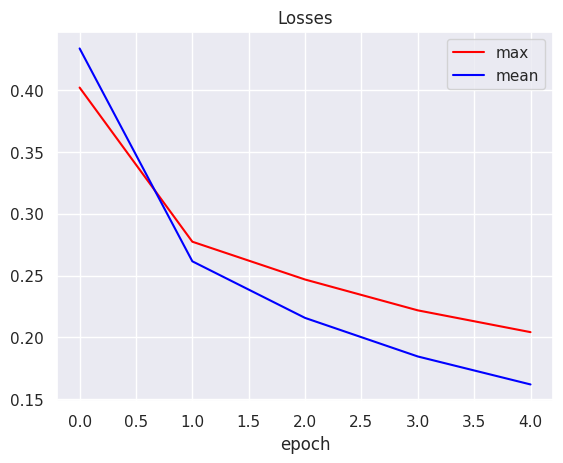

In [37]:
for (name, values), color in zip(metrics.items(), ['red', 'blue']):
    plt.plot(np.arange(len(metrics[name]['train_loss'])), metrics[name]['train_loss'], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 90.32
Лучшая accuracy для подхода mean: 90.74


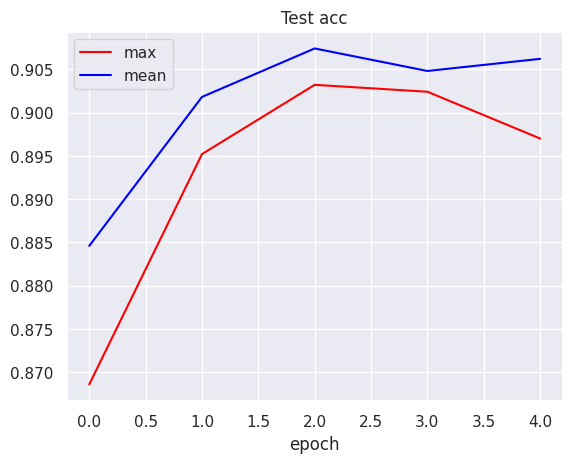

In [38]:
for (name, values), color in zip(metrics.items(), ['red', 'blue']):
    plt.plot(np.arange(len(metrics[name]['test_acc'])), metrics[name]['test_acc'], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(metrics[name]['test_acc']) * 100):.2f}")
plt.title('Test acc')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [39]:
# Валидация на полном тесте

model = CharLM(hidden_dim=256, vocab_size=len(vocab), aggregation_type=best_agg_type).to(device)
model.load_state_dict(torch.load(default_model_path + '/no_diff', weights_only=True))

print(evaluate(model, test_dataset), 'accuracy with best model on full test')

0.9071999788284302 accuracy with best model on full test


# Поробуем использовать модель с LSTM вместо RNN

In [13]:
class LSTM_LM(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.LSTM = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.LSTM(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [ ]:
metrics_lstm, best_agg_type_lstm = training_loop(LSTM_LM, device, 'LSTM')

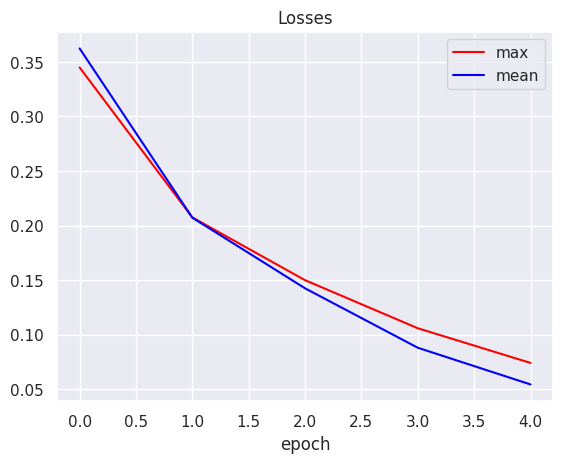

In [20]:
for (name, values), color in zip(metrics_lstm.items(), ['red', 'blue']):
    plt.plot(np.arange(len(metrics_lstm[name]['train_loss'])), metrics_lstm[name]['train_loss'], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 91.30
Лучшая accuracy для подхода mean: 91.60


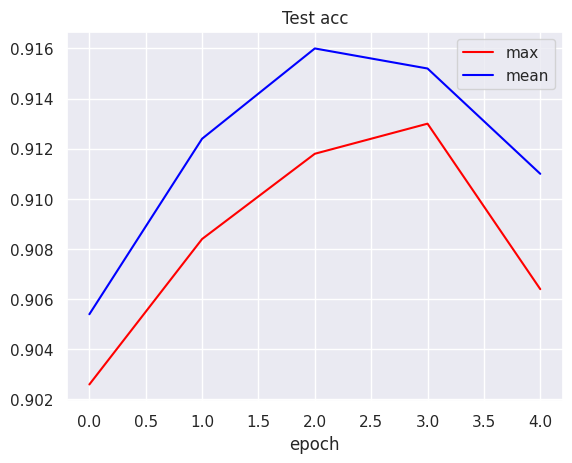

In [21]:
for (name, values), color in zip(metrics_lstm.items(), ['red', 'blue']):
    plt.plot(np.arange(len(metrics_lstm[name]['test_acc'])), metrics_lstm[name]['test_acc'], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(metrics_lstm[name]['test_acc']) * 100):.2f}")
plt.title('Test acc')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [22]:
# Валидация на полном тесте

model = LSTM_LM(hidden_dim=256, vocab_size=len(vocab), aggregation_type=best_agg_type_lstm).to(device)
model.load_state_dict(torch.load(default_model_path + '/LSTM', weights_only=True))

print(evaluate(model, test_dataset), 'accuracy with best model on full test')

0.9138000011444092 accuracy with best model on full test


# Доработаем LSTM модель, попробуем сделать hidden_size больше

In [25]:
metrics_lstm_mod, best_agg_type_lstm_mod = training_loop(LSTM_LM, device, 'LSTM_mod', hidden_dim=1024, num_epochs=8)

Training model with aggregation type max
Training


Training epoch 1: 100%|██████████| 3750/3750 [01:27<00:00, 42.75it/s]


new best acc 0.9070000052452087 with agg type max


Training epoch 2: 100%|██████████| 3750/3750 [01:27<00:00, 42.75it/s]


new best acc 0.9081999659538269 with agg type max


Training epoch 8: 100%|██████████| 3750/3750 [01:27<00:00, 42.71it/s]


Training model with aggregation type mean
Training


Training epoch 1: 100%|██████████| 3750/3750 [01:26<00:00, 43.15it/s]


new best acc 0.9179999828338623 with agg type mean


Training epoch 8: 100%|██████████| 3750/3750 [01:26<00:00, 43.13it/s]


0.9179999828338623 mean best_acc on eval with best 


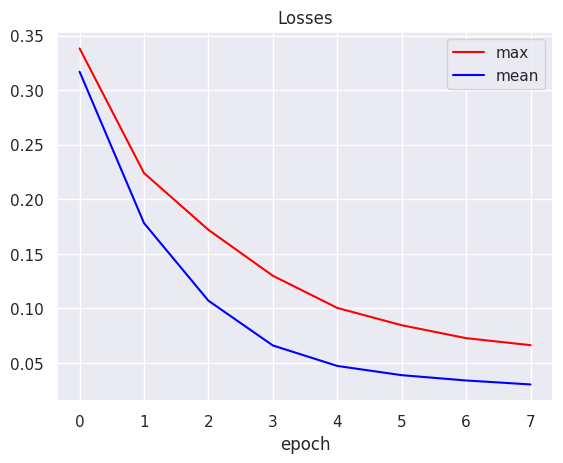

In [26]:
for (name, values), color in zip(metrics_lstm_mod.items(), ['red', 'blue']):
    plt.plot(np.arange(len(metrics_lstm_mod[name]['train_loss'])), metrics_lstm_mod[name]['train_loss'], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 90.82
Лучшая accuracy для подхода mean: 91.80


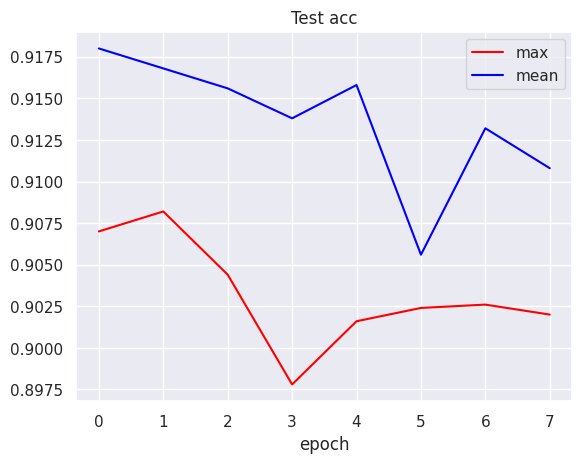

In [27]:
for (name, values), color in zip(metrics_lstm_mod.items(), ['red', 'blue']):
    plt.plot(np.arange(len(metrics_lstm_mod[name]['test_acc'])), metrics_lstm_mod[name]['test_acc'], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(metrics_lstm_mod[name]['test_acc']) * 100):.2f}")
plt.title('Test acc')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [43]:
# Валидация на полном тесте

model = LSTM_LM(hidden_dim=1024, vocab_size=len(vocab), aggregation_type=best_agg_type_lstm_mod).to(device)
model.load_state_dict(torch.load(default_model_path + '/LSTM_mod', weights_only=True))

print(evaluate(model, test_dataset), 'accuracy with best model on full test')

0.9181999564170837 accuracy with best model on full test


# Попробуем объединить результаты pooling и последнее скрытое состояние для передачи в fc

In [24]:
class StackedRNN(nn.Module):
    def __init__(
        self, hidden_dim: int, vocab_size: int, num_classes: int = 4,
        aggregation_type: str = 'max'
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(2*hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, hidden_state = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]
        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        output = torch.cat([output, hidden_state.squeeze(0)], dim=-1)
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [25]:
metrics_stacked, best_agg_type_stacked = training_loop(StackedRNN, device, 'stacked_rnn')

Training model with aggregation type max
Training


Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

Training model with aggregation type mean
Training


Training epoch 1:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4:   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5:   0%|          | 0/3750 [00:00<?, ?it/s]

0.9101999998092651 max best_acc on eval with best 


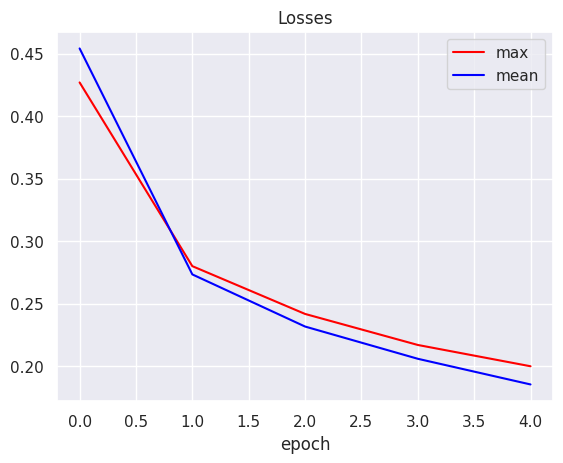

In [26]:
for (name, values), color in zip(metrics_stacked.items(), ['red', 'blue']):
    plt.plot(np.arange(len(metrics_stacked[name]['train_loss'])), metrics_stacked[name]['train_loss'], color=color, label=name)

plt.title('Losses')
plt.xlabel("epoch")
plt.legend()
plt.show()

Лучшая accuracy для подхода max: 91.02
Лучшая accuracy для подхода mean: 90.24


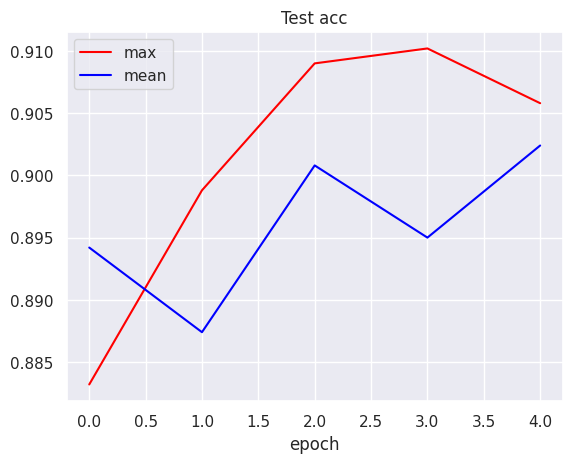

In [27]:
for (name, values), color in zip(metrics_stacked.items(), ['red', 'blue']):
    plt.plot(np.arange(len(metrics_stacked[name]['test_acc'])), metrics_stacked[name]['test_acc'], color=color, label=name)
    print(f"Лучшая accuracy для подхода {name}: {(max(metrics_stacked[name]['test_acc']) * 100):.2f}")

plt.title('Test acc')
plt.xlabel("epoch")
plt.legend()
plt.show()

In [28]:
# Валидация на полном тесте

model = StackedRNN(hidden_dim=256, vocab_size=len(vocab), aggregation_type=best_agg_type_stacked).to(device)
model.load_state_dict(torch.load(default_model_path + '/stacked_rnn', weights_only=True))

print(evaluate(model, test_dataset), 'accuracy with best model on full test')

0.9085999727249146 accuracy with best model on full test


# Результаты и выводы

В качестве улучшения я делал несколько вещей:
1) Пробовал сменить архитектуру на LSTM, это принесло хороший результат.
2) Так же пробовал сделать объединение выходов pooling и последнего скрытого состояния в полносвязный слой. Это не принесло результатов.

Сходимость в моделях на loss функции везде стабильная, то есть модель обучается и работает лучше и лучше с каждой эпохой. Но если смотреть на тестовую точность, видно, что она скачет. Это говорит о том, что модель начинает переобучаться под обучающую выборку.
Колебания в тестовой метрике являются существенными, нельзя сказать, что модель стабильно обучается. 

Наибольшое улучшение было получено за счет смены архитектуры на LSTM и сменой hidden_size c 256 на 1024 в LSTM архитектуре:

In [42]:
# Валидация на полном тесте
model = LSTM_LM(hidden_dim=1024, vocab_size=len(vocab), aggregation_type=best_agg_type_lstm_mod).to(device)
model.load_state_dict(torch.load(default_model_path + '/LSTM_mod', weights_only=True))

print(evaluate(model, test_dataset), 'accuracy with best model on full test')

0.917199969291687 accuracy with best model on full test
